In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim

import matplotlib.pyplot as plt

import skimage
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage import filters

import os
import glob

import time

def norm(im):
    return (im - np.min(im)) / (np.max(im) - np.min(im))


from pathlib import Path
ROOT = Path('/home/jay/data/StatisticalImageProcessing/')
train_image_path = ROOT / "Jay_Images/train3/"
train_mask_path = ROOT / "Jay_Images/train_masks3/"
test_image_path = ROOT / "Jay_Images/test/"

save_name = 'model7_results/'

In [ ]:
size_x = 1024
size_y = 1024
train_images = np.zeros((len(os.listdir(train_image_path)),size_x,size_y))
train_labels = np.zeros_like(train_images)

print('Train')
for i in range(len(train_images)):
    if i % 500 == 0:
        print('\t{} / {}'.format(i,len(train_images)))
    train_images[i] = norm(skimage.color.rgb2gray(plt.imread(os.path.join(train_image_path,sorted(os.listdir(train_image_path))[i]))))
train_images = train_images.reshape(-1,1,1024,1024)
#np.save('train_images.npy',train_images)
    
print('Test')
for i in range(len(train_labels)):
    if i % 500 == 0:
        print('\t{} / {}'.format(i,len(train_labels)))
    train_labels[i] = plt.imread(os.path.join(train_mask_path,sorted(os.listdir(train_mask_path))[i]))  
#np.save('train_labels.npy',train_labels)

#train_images = np.load('train_images.npy',mmap_mode='r+')
#train_labels = np.load('train_labels.npy',mmap_mode='r+')
    
tensor_im = torch.stack([torch.Tensor(i) for i in train_images])
tensor_labels = torch.stack([torch.Tensor(i) for i in train_labels])

dataset = torch.utils.data.TensorDataset(tensor_im,tensor_labels)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=32,shuffle=True)

In [ ]:
n = int(np.random.rand() * len(train_images))

train_im = train_images[n,0]
test_im = train_labels[n]

print(n)

f,a = plt.subplots(figsize=(8,8))
a.imshow(train_im,plt.cm.gray)
a.contour(test_im,[test_im > 0],colors=['red'])
a.axis('off')

### Training

In [2]:
class UNet3(nn.Module):
    def __init__(self):
        super(UNet3,self).__init__()
        self.conv0 = nn.Conv2d(1,8,3,dilation=1,padding=1)
        self.b0 = nn.BatchNorm2d(8)
        self.conv1 = nn.Conv2d(8,16,3,dilation=1,padding=1)
        self.b1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3,dilation=1,padding=1)
        self.b2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,64,3,dilation=1,padding=1)
        self.b3 = nn.BatchNorm2d(64)
        self.conv4 = nn.ConvTranspose2d(64,32,3,stride=2,padding=(1,1))
        self.b4 = nn.BatchNorm2d(32)
        self.conv4_1 = nn.Conv2d(96,96,3,padding=1)
        self.b4_1 = nn.BatchNorm2d(96)
        self.conv5 = nn.ConvTranspose2d(96,32,3,stride=2,padding=(1,1))
        self.b5 = nn.BatchNorm2d(32)
        self.conv5_1 = nn.Conv2d(64,64,3,padding=1)
        self.b5_1 = nn.BatchNorm2d(64)
        self.conv6 = nn.ConvTranspose2d(64,16,3,stride=2,padding=(1,1))
        self.b6 = nn.BatchNorm2d(16)
        self.conv6_1 = nn.Conv2d(32,32,3,padding=1)
        self.b6_1 = nn.BatchNorm2d(32)
        self.conv7 = nn.ConvTranspose2d(32,16,3,stride=2,padding=(1,1))
        self.b7 = nn.BatchNorm2d(16)
        self.conv7_1 = nn.Conv2d(24,24,3,padding=1)
        self.b7_1 = nn.BatchNorm2d(24)
        self.conv8 = nn.Conv2d(24,8,3,padding=(1,1))
        self.b8 = nn.BatchNorm2d(8)
        self.conv8_1 = nn.Conv2d(8,8,3,padding=1)
        self.b8_1 = nn.BatchNorm2d(8)
        self.conv9 = nn.Conv2d(8,2,1)
        self.b9 = nn.BatchNorm2d(2)
        self.pool = nn.MaxPool2d(2,2)
        self.Softmax = nn.Softmax(dim=1)

        
    ###  Uncomment lines below to add second convolutional layer for upsampling
    def forward(self,x):
        c0 = self.b0(F.leaky_relu(self.conv0(x)))
        c0out = self.pool(c0)
        c1 = self.b1(F.leaky_relu(self.conv1(c0out)))
        c1out = self.pool(c1)
        c2 = self.b2(F.leaky_relu(self.conv2(c1out)))
        c2out = self.pool(c2)
        c3 = self.b3(F.leaky_relu(self.conv3(c2out)))
        c3out = self.pool(c3)
        c4 = self.b4(F.leaky_relu(self.conv4(c3out,output_size=c3.size())))
        c4cat = torch.cat((c4,c3),dim=1)
        #c4cat = self.b4_1(F.leaky_relu(self.conv4_1(c4cat)))
        c5 = self.b5(F.leaky_relu(self.conv5(c4cat,output_size=c2.size())))
        c5cat = torch.cat((c5,c2),dim=1)
        #c5cat = self.b5_1(F.leaky_relu(self.conv5_1(c5cat)))
        c6 = self.b6(F.leaky_relu(self.conv6(c5cat,output_size=c1.size())))
        c6cat = torch.cat((c6,c1),dim=1)
        #c6cat = self.b6_1(F.leaky_relu(self.conv6_1(c6cat)))
        c7 = self.b7(F.leaky_relu(self.conv7(c6cat,output_size=c0.size())))
        c7cat = torch.cat((c7,c0),dim=1)
        #c7cat = self.b7_1(F.leaky_relu(self.conv7_1(c7cat)))
        c8 = self.b8(F.leaky_relu(self.conv8(c7cat)))
        #c8 = self.b8_1(F.leaky_relu(self.conv8_1(c8)))
        c9 = self.b9(F.leaky_relu(self.conv9(c8)))
        out = self.Softmax(c9)
#        
        return out


class UNet7(nn.Module):
    def __init__(self,kernel_size=7):
        super(UNet7,self).__init__()
        self.conv0 = nn.Conv2d(1,8,kernel_size,dilation=1,padding=3)
        self.b0 = nn.BatchNorm2d(8)
        self.conv1 = nn.Conv2d(8,16,kernel_size,dilation=1,padding=3)
        self.b1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,kernel_size,dilation=1,padding=3)
        self.b2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,64,kernel_size,dilation=1,padding=3)
        self.b3 = nn.BatchNorm2d(64)
        self.conv4 = nn.ConvTranspose2d(64,32,kernel_size,stride=2,padding=(3,3))
        self.b4 = nn.BatchNorm2d(32)
        self.conv4_1 = nn.Conv2d(96,96,kernel_size,padding=3)
        self.b4_1 = nn.BatchNorm2d(96)
        self.conv5 = nn.ConvTranspose2d(96,32,kernel_size,stride=2,padding=(3,3))
        self.b5 = nn.BatchNorm2d(32)
        self.conv5_1 = nn.Conv2d(64,64,kernel_size,padding=3)
        self.b5_1 = nn.BatchNorm2d(64)
        self.conv6 = nn.ConvTranspose2d(64,16,kernel_size,stride=2,padding=(3,3))
        self.b6 = nn.BatchNorm2d(16)
        self.conv6_1 = nn.Conv2d(32,32,kernel_size,padding=3)
        self.b6_1 = nn.BatchNorm2d(32)
        self.conv7 = nn.ConvTranspose2d(32,16,kernel_size,stride=2,padding=(3,3))
        self.b7 = nn.BatchNorm2d(16)
        self.conv7_1 = nn.Conv2d(24,24,kernel_size,padding=1)
        self.b7_1 = nn.BatchNorm2d(24)
        self.conv8 = nn.Conv2d(24,8,3,padding=(1,1))
        self.b8 = nn.BatchNorm2d(8)
        self.conv8_1 = nn.Conv2d(8,8,3,padding=1)
        self.b8_1 = nn.BatchNorm2d(8)
        self.conv9 = nn.Conv2d(8,2,1)
        self.b9 = nn.BatchNorm2d(2)
        self.pool = nn.MaxPool2d(2,2)
        self.Softmax = nn.Softmax(dim=1)

        
    ###  Uncomment lines below to add second convolutional layer for upsampling
    def forward(self,x):
        c0 = self.b0(F.leaky_relu(self.conv0(x)))
        c0out = self.pool(c0)
        c1 = self.b1(F.leaky_relu(self.conv1(c0out)))
        c1out = self.pool(c1)
        c2 = self.b2(F.leaky_relu(self.conv2(c1out)))
        c2out = self.pool(c2)
        c3 = self.b3(F.leaky_relu(self.conv3(c2out)))
        c3out = self.pool(c3)
        c4 = self.b4(F.leaky_relu(self.conv4(c3out,output_size=c3.size())))
        c4cat = torch.cat((c4,c3),dim=1)
#        #c4cat = self.b4_1(F.leaky_relu(self.conv4_1(c4cat)))
        c5 = self.b5(F.leaky_relu(self.conv5(c4cat,output_size=c2.size())))
        c5cat = torch.cat((c5,c2),dim=1)
#        #c5cat = self.b5_1(F.leaky_relu(self.conv5_1(c5cat)))
        c6 = self.b6(F.leaky_relu(self.conv6(c5cat,output_size=c1.size())))
        c6cat = torch.cat((c6,c1),dim=1)
#        #c6cat = self.b6_1(F.leaky_relu(self.conv6_1(c6cat)))
        c7 = self.b7(F.leaky_relu(self.conv7(c6cat,output_size=c0.size())))
        c7cat = torch.cat((c7,c0),dim=1)
#        #c7cat = self.b7_1(F.leaky_relu(self.conv7_1(c7cat)))
        c8 = self.b8(F.leaky_relu(self.conv8(c7cat)))
#        #c8 = self.b8_1(F.leaky_relu(self.conv8_1(c8)))
        c9 = self.b9(F.leaky_relu(self.conv9(c8)))
        out = self.Softmax(c9)
#        
        return out

In [ ]:
model = UNet7()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)
#model = nn.DataParallel(model)

model.train()

In [ ]:
loss_history = []
start = time.time()
for epoch in range(50):

    start_epoch = time.time()
    print('Epoch {}'.format(epoch+1))
    running_loss = 0.0
    n = 0
#    scheduler.step()
    for i, data in enumerate(dataloader,0):

        inputs,labels = data
        inputs,labels = inputs.to(device),labels.to(device)
#        print(inputs.size(),labels.size())
      
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs,labels.long())
        loss.backward()        
        optimizer.step()
        
        
        running_loss += loss.item()
        if i % (len(dataloader)/10) == 0:
            print('{}%'.format(n))
            n += 10
    print('loss: {}'.format(running_loss/len(dataloader)))
    print('Epoch time: {}\n'.format(time.time() - start_epoch))
    loss_history.append(running_loss/len(dataloader))
    
    
    if (epoch + 1) % 5 == 0:
        f,a = plt.subplots(figsize=(5,5))
        im = inputs.detach().cpu().numpy()[0,0,:,:]
        out_raw = outputs.detach().cpu().numpy()[0,0,:,:]
        a.imshow(im,plt.cm.gray)
        a.contour(out_raw,[filters.threshold_otsu(out_raw)],colors=['red'])
        #a.set_title('Raw   Max={}'.format(np.max(out_raw)))
        a.axis('off')
        f.savefig(save_name+'model7_e{}.jpg'.format(epoch+1))
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
        },save_name+'model7_e{}.pt'.format(epoch+1))
print('Finished Training')
print('Total Time: {}'.format(time.time() - start))


### Plot loss vs epoch
f,a = plt.subplots(figsize=(10,10)) 
a.set_xlabel('Epoch') 
a.set_ylabel('Loss') 
#a.set_title('UNet 04032019') 
a.plot(range(len(loss_history)),loss_history) 
f.savefig(save_name+'model7_Loss.jpg')

In [ ]:
#out = outputs.detach().cpu().numpy()

In [ ]:
#ins = inputs.detach().cpu().numpy()
#f,a = plt.subplots(figsize=(10,10))
#a.imshow(ins[0,0],plt.cm.gray)

In [ ]:
#f,a = plt.subplots(figsize=(10,10))
#a.imshow(ins[0,0],plt.cm.gray)
#a.contour(out[0,0],[filters.threshold_otsu(out[0,0])],colors=['red'])

## Inference

In [3]:
model = UNet7()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)
#model = nn.DataParallel(model)

checkpoint = torch.load('model7_results/model7_e50.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.eval()

cuda:0


DataParallel(
  (module): UNet7(
    (conv0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (b0): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (b1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (b2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (b3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (b4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4_1): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (b4_1): BatchNorm2d(96, eps=1e-0

In [16]:
#size_x = 1024
#size_y = 1024
#test_images = np.zeros((len(os.listdir(test_image_path)),size_x,size_y))
#
#print('Train')
#for i in range(len(test_images)):
#    if i % 500 == 0:
#        print('\t{} / {}'.format(i,len(test_images)))
#    test_images[i] = norm(skimage.color.rgb2gray(plt.imread(os.path.join(test_image_path,sorted(os.listdir(test_image_path))[i]))))
#test_images = test_images.reshape(-1,1,1024,1024)
#np.save('test_images.npy',test_images)

test_images = np.load('test_images.npy')
tensor_images = torch.stack([torch.Tensor(i) for i in test_images])

batch_size=32
test_dataset = torch.utils.data.TensorDataset(tensor_images)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [23]:
outputs = np.zeros((len(test_images),2,1024,1024))

for i, data in enumerate(test_dataloader,0):
    inputs = data[0]
    inputs = inputs.to(device)
    
    out = model(inputs).detach().cpu().numpy()
    outputs[i*batch_size:i*batch_size+batch_size] = out
    
np.save('model7_test_output.npy',outputs)
np.save('model7_test_output_1layer',outputs[:,0])

85


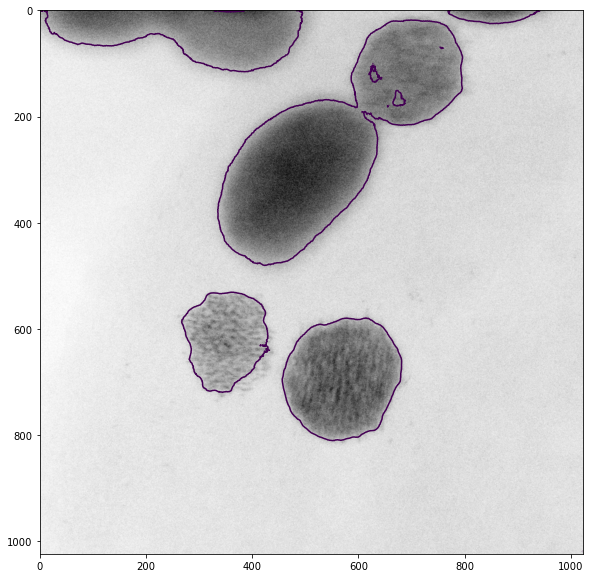

In [22]:
n = int(np.random.rand() * len(test_images))

f,a = plt.subplots(figsize=(10,10))
a.imshow(test_images[n,0],plt.cm.gray)
a.contour(outputs[n,0],[filters.threshold_otsu(outputs[n,0])])
print(n)

In [24]:
os.mkdir('test_output')
n = 0
for i in range(len(test_images)):
    plt.imsave('test_output/{:04d}.png'.format(n),outputs[i,0])
    n += 1

100


(-0.5, 1023.5, 1023.5, -0.5)

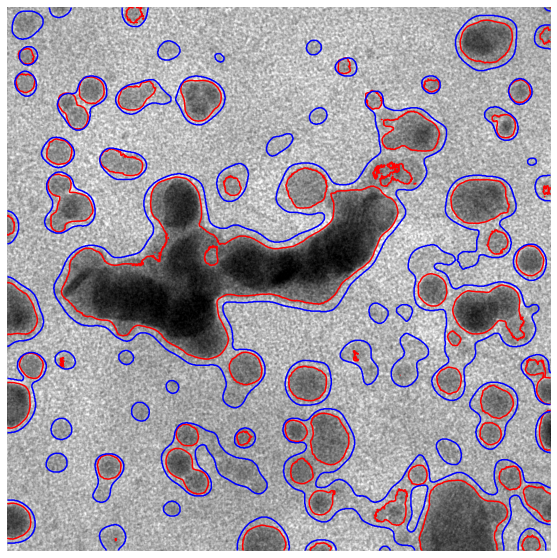

In [50]:
n = int(np.random.rand() * len(test_images))
print(n)

f,a = plt.subplots(figsize=(10,10))
a.imshow(test_images[n,0],plt.cm.gray)
a.contour(outputs[n,0],[filters.threshold_otsu(outputs[n,0])],colors=['red'])

ground_truth = plt.imread(os.path.join('Jay_Images/test_masks',sorted(os.listdir('Jay_Images/test_masks'))[n+1]))
a.contour(ground_truth,[filters.threshold_otsu(ground_truth)],colors=['blue'])
a.axis('off')